# 2023-09-05 · Ceil spikes 

In [2]:
include("lib/Nto1.jl")

[IJulia init done]
using Revise … ✔ (0.2 s)
using Units … ✔
using Nto1AdEx … ✔
using ConnectionTests … ✔
using ConnTestEval … ✔
using StatsBase … ✔ (0.2 s)


In [5]:
N = 6500
duration = 10minutes

@time sim = Nto1AdEx.sim(N, duration, record_all=true);

  2.356347 seconds (6.02 M allocations: 1.383 GiB, 19.15% gc time)


In [18]:
@time sim_ceil = Nto1AdEx.sim(N, duration, ceil_spikes=true);

  1.984199 seconds (29.38 k allocations: 912.805 MiB, 12.79% gc time, 0.36% compilation time)


In [20]:
include("lib/plot.jl")

import PythonCall … ✔ (1.8 s)
import PythonPlot … ✔ (3.5 s)
using Sciplotlib … ✔ (0.5 s)
using PhDPlots … ✔


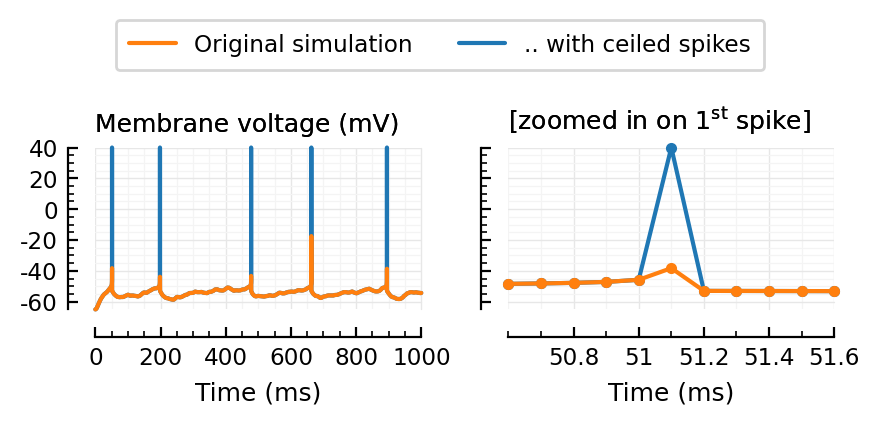

In [47]:
function ceilplot(; tlim, marker=nothing, ax, kw...)
    plotsig(sim_ceil.V / mV, tlim, ms, label=".. with ceiled spikes"; ax, marker, kw...);
    plotsig(sim.V / mV, tlim, ms, label="Original simulation"; ax, marker, kw...);
    # legend(ax, reorder=[1=>2]);
end

fig, axs = plt.subplots(ncols=2, figsize=(mtw, 0.4*mtw), sharey=true)
ceilplot(tlim = [0, 1000], ax=axs[0], hylabel="Membrane voltage (mV)");
ceilplot(tlim = [50.56, 51.6], marker=".", ax=axs[1], hylabel=L"[zoomed in on $1^{\mathrm{st}}$ spike]");
axis = axs[1].xaxis
t = mpl.ticker
axis.set_minor_locator(t.MultipleLocator(0.1))
# rm_ticks_and_spine(axs[1], "left")
l = axs[0].get_lines()
plt.figlegend(handles=[l[1], l[0]], ncols=2, loc="lower center", bbox_to_anchor=(0.5, 1))
plt.tight_layout();

In [12]:
t = sim.spiketimes[1]
t / ms

51.2

In [13]:
(; Δt, Eₑ, Eᵢ, Δₜ, Vₜ, gₗ, Eₗ, C) = Nto1AdEx

i = round(Int, t/Δt)  # The spiketime `t` is one sample after where we want, but this i is correct

512

In [25]:
n = sim.recording[i]

(; V, gₑ, gᵢ, w) = n
V / mV

-38.2

In [26]:
Iₛ = gₑ*(V - Eₑ) + gᵢ*(V - Eᵢ)
DₜV  = (-gₗ*(V - Eₗ) + gₗ*Δₜ*exp((V-Vₜ)/Δₜ) - Iₛ - w) / C

V_new = V + Δt * DₜV
V_new / mV

9.66E+04

In [27]:
V_new / volt

96.6

In [16]:
DₜV

9.67E+05

In [17]:
n.DₜV

75.6

So yeah, why the discrep here.

"Ah, it's cause the n.V is what we get _after_ calculating n.DₜV, in simcode. Whereas here, we re-used that V. We'd get same result if we do our calc here with (V,w,g) values of prev i"

In [22]:
n = sim.recording[i-1]

(; V, gₑ, gᵢ, w) = n
V / mV

-45.8

In [23]:
Iₛ = gₑ*(V - Eₑ) + gᵢ*(V - Eᵢ)
DₜV  = (-gₗ*(V - Eₗ) + gₗ*Δₜ*exp((V-Vₜ)/Δₜ) - Iₛ - w) / C

V_new = V + Δt * DₜV
V_new / mV

-38.2

Yeah, okay. :)

("Exp grows fast!")

In [50]:
savefig_phd("ceil_spikes", fig)

Saved at `../thesis/figs/ceil_spikes.pdf`